In [1]:
import glob
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from lmfit import Model
from scipy.constants import physical_constants

In [2]:
# Define the directory path and pattern to match the .dat files
file_pattern = 'Late April EPR results - powder and preform fragments/Aurelien/20240430*/**/EDFS*.dat'

# Use glob to get a list of .dat files
file_list = glob.glob(file_pattern, recursive=True)
print(file_list)

field_all = []
int_all = []
int2_all = []

# Loop over each file in the list
for fname in file_list:
    # Read the data from the .dat file
    data = pd.read_csv(fname, sep=r"\s+", header=None).to_numpy()
    print(data[0])
    
    outputRow = 0
    field_column_index = 1  # 0-based index for the second column
    int_column_index = 2    # 0-based index for the third column
    int2_column_index = 3    # 0-based index for the third column
    
    for inputRow in range(1,data.shape[0]):
        outputRow += 1
        
        # Allocate data into variables
        if len(field_all) < outputRow:
            field_all.append([None] * len(file_list))
            int_all.append([None] * len(file_list))
            int2_all.append([None] * len(file_list))
        
        field_all[outputRow-1][file_list.index(fname)] = data[inputRow, field_column_index]  # G
        int_all[outputRow-1][file_list.index(fname)] = data[inputRow, int_column_index]      # arb units
        int2_all[outputRow-1][file_list.index(fname)] = data[inputRow, int2_column_index]      # arb units

# print(field_all)

# Convert lists to numpy arrays
field_all = np.array(field_all, dtype=np.float64)
int_all = np.array(int_all, dtype=np.float64)
int2_all = np.array(int2_all, dtype=np.float64)

print("Field data (G):")
print(field_all)

print("Intensity data (arb units):")
print(int_all)

print("Intensity 2 data (arb units):")
print(int2_all)

['Late April EPR results - powder and preform fragments/Aurelien/20240430_preformfiber30kgy/EDFS_40K.dat']
['index' 'Field' '[G]' 'Intensity' '[]' 'Intensity' '[]']
Field data (G):
[[3350.        ]
 [3350.19550342]
 [3350.39100684]
 ...
 [3549.60899316]
 [3549.80449658]
 [3550.        ]]
Intensity data (arb units):
[[ 8438.]
 [14842.]
 [ 6696.]
 ...
 [19254.]
 [14876.]
 [16593.]]
Intensity 2 data (arb units):
[[ -553.]
 [-8921.]
 [-6054.]
 ...
 [ 7374.]
 [ 8280.]
 [ 2255.]]


In [3]:
# Define the directory path and pattern to match the .DSC
file_pattern_dsc=file_pattern.split('.dat')[0]+'.DSC'

# Use glob to get a list of .DSC files
DSC_list = glob.glob(file_pattern_dsc, recursive=True)
print(DSC_list)
print()

for fname in DSC_list:
    with open(fname,'r') as f:
        LINES=f.readlines()
        for l in LINES:
            if ("MWFQ" in l):
                MWFreq = float(l.split(' ')[-1])
print(f"Microwave frequency for this experiment : {MWFreq*1e-9} GHz")

# Constants
h = physical_constants['Planck constant'][0] # J.s Planck's constant
mu_b = physical_constants['Bohr magneton'][0] #J/T Bohr's magneton
Gauss = 1e-4 #T/G

def g_Lande(B):
    """Converts magnetic field in Gauss into g value"""
    return h*MWFreq/(mu_b*B*Gauss)

def Bfromg(g):
    """Converts g value into magnetic field in Gauss"""
    return h*MWFreq/(mu_b*g*Gauss)

# print(g_Lande(3455))

['Late April EPR results - powder and preform fragments/Aurelien/20240430_preformfiber30kgy/EDFS_40K.DSC']

Microwave frequency for this experiment : 9.714986000000001 GHz


In [4]:
# Function to calculate the resonance condition
def resonance_field(g, theta, phi, Freq=MWFreq*1e-9):
    g_eff = np.sqrt((g[0]*np.sin(theta)*np.cos(phi))**2 +
                    (g[1]*np.sin(theta)*np.sin(phi))**2 +
                    (g[2]*np.cos(theta))**2)
    B_res = h * Freq * 1e9 / (mu_b * g_eff) * 1e3  # Convert to mT
    return B_res

def EPR_signal(g, sigma_broad=1e-4, maxvalue=1., magnitude=None, B_min=3370,B_max=3520,n_orientations=int(5e5),Bunit="G"):
    """
    g : g-tensor components
    sigma_broad - standard deviation for Gaussian broadening inBunit (G or mT)
    B_min & B_max - magnetic field range in Bunit (G or mT)
    n_orientations - number of random orientations
    """
    assert Bunit in ["mT","G"]
    
    g=np.array(g)
    
    # Magnetic field array
    B = np.linspace(B_min, B_max, 1000)  # Magnetic field in mT

    # Generate random orientations
    thetas = np.arccos(2 * np.random.rand(n_orientations) - 1)
    phis = 2 * np.pi * np.random.rand(n_orientations)
    
    # Simulate the EPR signal
    EPR_signal = np.zeros_like(B)
    for theta, phi in zip(thetas, phis):
        B_res = resonance_field(g, theta, phi) #mT
        if Bunit=="G":
            B_res*=10
        EPR_signal += np.exp(- ((B - B_res)/(sigma_broad))**2 / 2)

    # Normalize the signal
    EPR_signal /= n_orientations
    EPR_signal = pd.Series(EPR_signal[:]).rolling(window=5, center=True).mean().bfill().ffill().to_numpy()
    if magnitude==None:
        assert maxvalue!=None
        EPR_signal = EPR_signal * maxvalue/np.max(EPR_signal)
    else:
        EPR_signal = EPR_signal * magnitude
    return EPR_signal

In [5]:
B_min,B_max=3370, 3520
# maxvalueplot= 2e5
B = np.linspace(B_min, B_max, 1000)

field=field_all.flatten()
intensity=int_all.flatten()
intensity/=np.max(intensity) #Normalize intensity because arbitrary unit
intensity_sm = pd.Series(intensity[:]).rolling(window=5, center=True).mean().bfill().ffill().to_numpy()
intensity2=int2_all.flatten()


right_field,right_intensity_sm = field[field>3460],intensity_sm[field>3460]
LOCMAX=right_field[np.argmax(right_intensity_sm)]
val_LOCMAX=np.max(right_intensity_sm)
print("Local maximum for 2nd resonance peak field :",LOCMAX)
print("E'_gamma g_iso field :",Bfromg(np.mean([2.0018,2.0006,2.0003])))

#recalibration of field based on E'_gamma peak
field = field - LOCMAX + Bfromg(np.mean([2.0018,2.0006,2.0003]))

g_values=g_Lande(field)

Local maximum for 2nd resonance peak field : 3465.73802541544
E'_gamma g_iso field : 3469.007675648947


In [6]:
#EPR Curve library
B_min,B_max=3370, 3520
maxvalueplot= 1#2e5
B = np.linspace(B_min, B_max, 1000)

DICOPOWDERS = {
# "NBOHC_1" : EPR_signal([1.999,2.0095,2.078], sigma_broad=1.3, maxvalue=maxvalueplot,Bunit="G"),#, B_min=B_recalib[0], B_max=B_recalib[1]),
# "NBOHC_2" : EPR_signal([2.0001,2.0102,2.078], sigma_broad=1.3, maxvalue=maxvalueplot,Bunit="G", B_min=B_recalib[0], B_max=B_recalib[1]),
"STH1" : EPR_signal([2.0027,2.0082,2.043], sigma_broad=1.3, maxvalue=maxvalueplot,Bunit="G"),#, B_min=B_recalib[0], B_max=B_recalib[1]),
# "mySTH1fortest" : EPR_signal([2.0025, 2.0075, 2.041], sigma_broad=1.3, maxvalue=maxvalueplot,Bunit="G"),#, B_min=B_recalib[0], B_max=B_recalib[1]),
"STH2" : EPR_signal([2.0054,2.0078,2.013], sigma_broad=2.0, maxvalue=maxvalueplot,Bunit="G"),#, B_min=B_recalib[0], B_max=B_recalib[1]),
# "STH2" : EPR_signal([2.002,2.0091,2.051], sigma_broad=1.3, maxvalue=maxvalueplot,Bunit="G", B_min=B_recalib[0], B_max=B_recalib[1]),
# "LancrySTH" : EPR_signal([2.002, 2.0091, 2.041], sigma_broad=1.3, maxvalue=maxvalueplot,Bunit="G"),#, B_min=B_recalib[0], B_max=B_recalib[1]),
# "LancryPOR" : EPR_signal([2.0018,2.0078,2.0416], sigma_broad=1.3, maxvalue=maxvalueplot,Bunit="G"),#, B_min=B_recalib[0], B_max=B_recalib[1]),
# "POR_1" : EPR_signal([2.0018,2.0078,2.067], sigma_broad=1.3, maxvalue=maxvalueplot,Bunit="G", B_min=B_recalib[0], B_max=B_recalib[1]),
# "POR_1" : EPR_signal([2.0020,2.0085,2.027], sigma_broad=1.3, maxvalue=maxvalueplot,Bunit="G", B_min=B_recalib[0], B_max=B_recalib[1]),
# "Epr_alpha" : EPR_signal([2.0018,2.0013,1.9998], sigma_broad=1.3, maxvalue=maxvalueplot,Bunit="G", B_min=B_recalib[0], B_max=B_recalib[1]),
# "Epr_beta" : EPR_signal([2.0018,2.0004,2.0004], sigma_broad=1.3, maxvalue=maxvalueplot,Bunit="G", B_min=B_recalib[0], B_max=B_recalib[1]),
# "LancryEpr_gamma" : EPR_signal([2.0018,2.0007,2.0004], sigma_broad=1.3, maxvalue=maxvalueplot,Bunit="G", B_min=B_recalib[0], B_max=B_recalib[1]), #ALMOST THE SAME AS BELOW
"Epr_gamma" : EPR_signal([2.0018,2.0006,2.0003], sigma_broad=1.5, maxvalue=maxvalueplot,Bunit="G"),#, B_min=B_recalib[0], B_max=B_recalib[1]),
# "Epr_delta" : EPR_signal([2.0018,2.0021,2.0021], sigma_broad=1.3, maxvalue=maxvalueplot,Bunit="G", B_min=B_recalib[0], B_max=B_recalib[1]),
}

<>:26: SyntaxWarning: invalid escape sequence '\g'
<>:26: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_43970/4033893492.py:26: SyntaxWarning: invalid escape sequence '\g'
  color='purple',label=f"$E'_\gamma$",linestyle='dotted')


0.3386311284575339


/tmp/ipykernel_43970/924150552.py:28: RuntimeWarning: divide by zero encountered in divide
  return h*MWFreq/(mu_b*g*Gauss)
/tmp/ipykernel_43970/924150552.py:28: RuntimeWarning: divide by zero encountered in divide
  return h*MWFreq/(mu_b*g*Gauss)


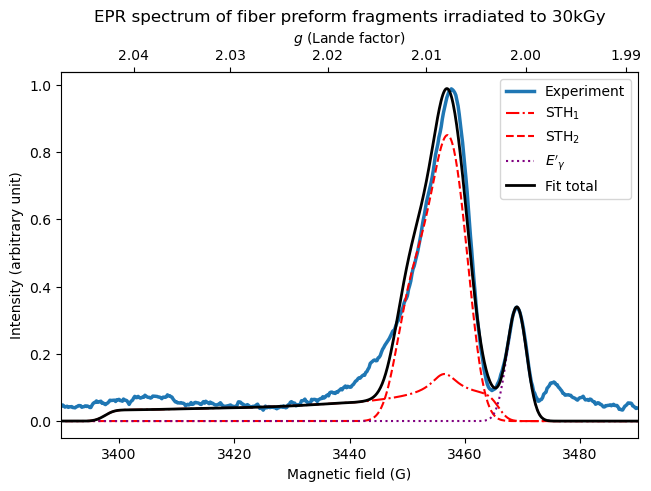

In [25]:

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(field,intensity_sm, label="Experiment",linewidth=2.5)
ax.set_xlabel("Magnetic field (G)")
ax.set_ylabel("Intensity (arbitrary unit)")
ax.set_title('EPR spectrum of fiber preform fragments irradiated to 30kGy')
secax = ax.secondary_xaxis('top', functions=(g_Lande, Bfromg))
secax.set_xlabel('$g$ (Lande factor)')
# ax.grid()

DICOMAGFACTOR = {
    "STH1":0.14,
    "STH2":0.85,
    "Epr_gamma":val_LOCMAX/np.max(DICOPOWDERS["Epr_gamma"]),
}

print(val_LOCMAX/np.max(DICOPOWDERS["Epr_gamma"]))

if DICOMAGFACTOR["STH1"]>0.:
    ax.plot(B, DICOPOWDERS["STH1"]*DICOMAGFACTOR["STH1"],
        color='red',label=f"STH$_1$",linestyle="dashdot")
if DICOMAGFACTOR["STH2"]>0.:
    ax.plot(B, DICOPOWDERS["STH2"]*DICOMAGFACTOR["STH2"],
        color='red',label=f"STH$_2$",linestyle='--')
if DICOMAGFACTOR["Epr_gamma"]>0.:
    ax.plot(B, DICOPOWDERS["Epr_gamma"]*DICOMAGFACTOR["Epr_gamma"],
        color='purple',label=f"$E'_\gamma$",linestyle='dotted')
TOTSPECT = np.zeros_like(DICOPOWDERS["STH2"])
for k in DICOMAGFACTOR.keys():
    TOTSPECT+=DICOPOWDERS[k]*DICOMAGFACTOR[k]
ax.plot(B, TOTSPECT, color='black', label='Fit total', linewidth=2)
ax.set_xlim(3390,3490)
# ax.set_xlim(3467,3475)
plt.legend()
# plt.show()

# fig.set_dpi(2000)
plt.savefig("EPRpreform.pdf")

/tmp/ipykernel_43970/924150552.py:28: RuntimeWarning: divide by zero encountered in divide
  return h*MWFreq/(mu_b*g*Gauss)
/tmp/ipykernel_43970/924150552.py:28: RuntimeWarning: divide by zero encountered in divide
  return h*MWFreq/(mu_b*g*Gauss)


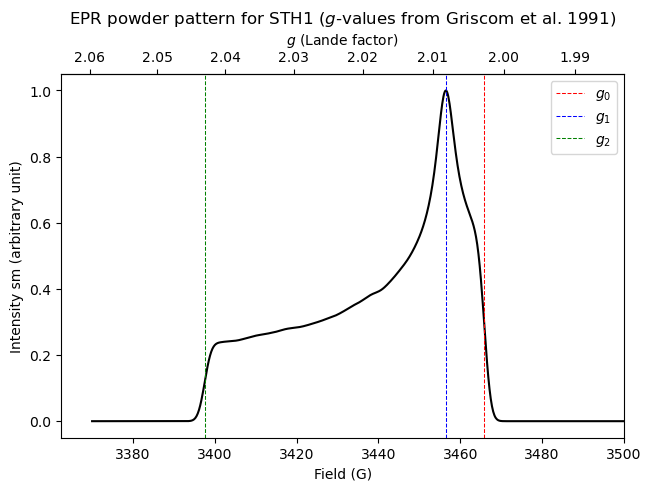

In [23]:
fig, ax = plt.subplots(constrained_layout=True)
ax.set_xlabel("Field (G)")
ax.set_ylabel("Intensity sm (arbitrary unit)")
ax.set_title('EPR powder pattern for STH1 ($g$-values from Griscom et al. 1991)')
secax = ax.secondary_xaxis('top', functions=(g_Lande, Bfromg))
secax.set_xlabel('$g$ (Lande factor)')
# ax.grid()

ax.plot(B, DICOPOWDERS["STH1"],color="black")
COLORS = ["red","blue","green"]
for i,g in enumerate([2.0027,2.0082,2.043]):
    ax.axvline(Bfromg(g),label=f"$g_{i}$",linewidth=0.75,linestyle="dashed",color=COLORS[i])
# ax.set_xlim(3390,3490)
ax.set_xlim(right=3500)
plt.legend()
# plt.show()

# fig.set_dpi(2000)
plt.savefig("PowderPatternSTH1.pdf")

# Fit

In [47]:
import itertools
from tqdm import tqdm

DICOPTI = {
"STH1" : {'g':[1.999,2.0095,2.078], "sigma_range":(0.5,2.), "mag_range":(0,0.3)},
"STH2" : {'g':[2.0054,2.0078,2.013], "sigma_range":(1,3), "mag_range":(0,0.3)},
"Epr_gamma" : {'g':[2.0018,2.0006,2.0003], "sigma_range":(0.5,2.), "mag_range":(0.3,0.35)},
}

discret=10

def Loss(Spect):
    return np.linalg.norm(np.interp(field[(field>3440) * (field<3480)], B, Spect)-intensity_sm[(field>3440) * (field<3480)])

def Spec_def(g,sigma):
    return EPR_signal(g, sigma_broad=sigma ,Bunit="G")

# ALLSPECSforD=[ {sigma:EPR_signal(DICOPTI[d]['g'], sigma_broad=sigma ,Bunit="G") for sigma in tqdm(np.linspace(*DICOPTI[d]["sigma_range"],num=discret))}  for d in (DICOPTI.keys())]
SIGRANGES=[ np.linspace(*DICOPTI[d]["sigma_range"],num=discret)  for d in DICOPTI.keys()]
MAGRANGES = [ np.linspace(*DICOPTI[d]["mag_range"],num=discret)  for d in DICOPTI.keys()]

best_sig,best_mag,best_loss=[0.,0.,0.],[0.,0.,0.],np.inf
for mags in tqdm(list(itertools.product(*MAGRANGES))):
    for j,sigs in enumerate(list(itertools.product(*SIGRANGES))):
        SPECs = [ALLSPECSforD[i][sigs[i]]  for i,d in enumerate(DICOPTI.keys())]
        loss = Loss( np.dot(mags, SPECs)  )
        if loss < best_loss:
            best_mag, best_sig, best_loss = mags, sigs, loss
print(mags, sigs, loss)



100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.19it/s]

(0.3, 0.3, 0.35) (2.0, 3.0, 2.0) 2.4942497985613965


/tmp/ipykernel_37402/924150552.py:28: RuntimeWarning: divide by zero encountered in divide
  return h*MWFreq/(mu_b*g*Gauss)


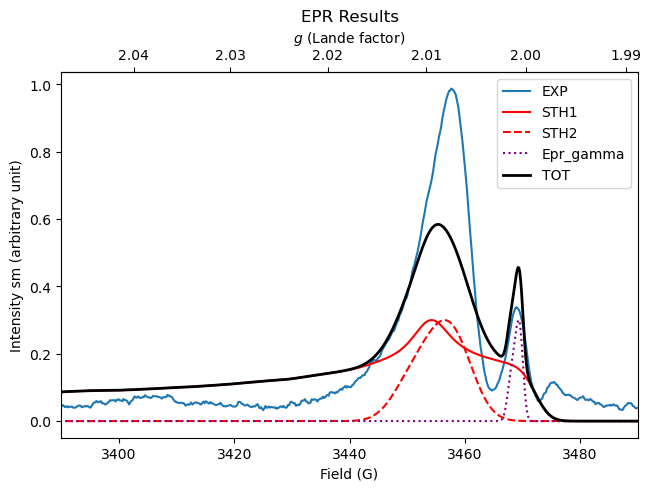

In [48]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(field,intensity_sm, label="EXP")
ax.set_xlabel("Field (G)")
ax.set_ylabel("Intensity sm (arbitrary unit)")
ax.set_title('EPR Results')
secax = ax.secondary_xaxis('top', functions=(g_Lande, Bfromg))
secax.set_xlabel('$g$ (Lande factor)')
# ax.grid()

DICOMAGFACTOR = {
    "STH1":best_mag[0],
    "STH2":best_mag[1],
    "Epr_gamma":best_mag[2],
}


if DICOMAGFACTOR["STH1"]>0.:
    ax.plot(B, DICOMAGFACTOR["STH1"]*ALLSPECSforD[0][best_sig[0]],
        color='red',label="STH1")
if DICOMAGFACTOR["STH2"]>0.:
    ax.plot(B, DICOMAGFACTOR["STH2"]*ALLSPECSforD[1][best_sig[1]],
        color='red',label="STH2",linestyle='--')
if DICOMAGFACTOR["Epr_gamma"]>0.:
    ax.plot(B, DICOMAGFACTOR["Epr_gamma"]*ALLSPECSforD[2][best_sig[2]],
        color='purple',label="Epr_gamma",linestyle='dotted')
TOTSPECT = np.zeros_like(DICOPOWDERS["STH2"])
for i,d in enumerate(DICOPTI.keys()):
    TOTSPECT+=DICOMAGFACTOR[d]*ALLSPECSforD[i][best_sig[i]]
ax.plot(B, TOTSPECT, color='black', label='TOT', linewidth=2)
ax.set_xlim(3390,3490)
# ax.set_xlim(3467,3475)
plt.legend()
plt.show()

# fig.set_dpi(2000)
# plt.savefig("EPR.pdf")